In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Navigate to the folder containing your files
%cd /content/drive/MyDrive/Data

# List contents
!ls


Mounted at /content/drive
/content/drive/MyDrive/Data
model-01-0.63-1.06.h5  test  test.zip  train  train.zip


In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications import MobileNet
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
from keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime

import cv2
import os
import io

In [ ]:
labels = ['cmd', 'cbb', 'cbsd', 'cgm', 'healthy']
x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 100

for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/Data/train',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = cv2.resize(image, (image_size, image_size),interpolation=cv2.INTER_CUBIC)
        x_train.append(image)
        y_train.append(labels.index(label))


100%|██████████| 316/316 [00:06<00:00, 48.23it/s]


In [ ]:
labels_2 = ['0']
for label2 in labels_2:
    testPath = os.path.join('/content/drive/MyDrive/Data/test',label2)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = cv2.resize(image, (image_size, image_size),interpolation=cv2.INTER_CUBIC)
        x_test.append(image)
        y_test.append(labels.index(label))

x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 3774/3774 [01:31<00:00, 41.37it/s] 


(5656, 100, 100, 3)
(3774, 100, 100, 3)


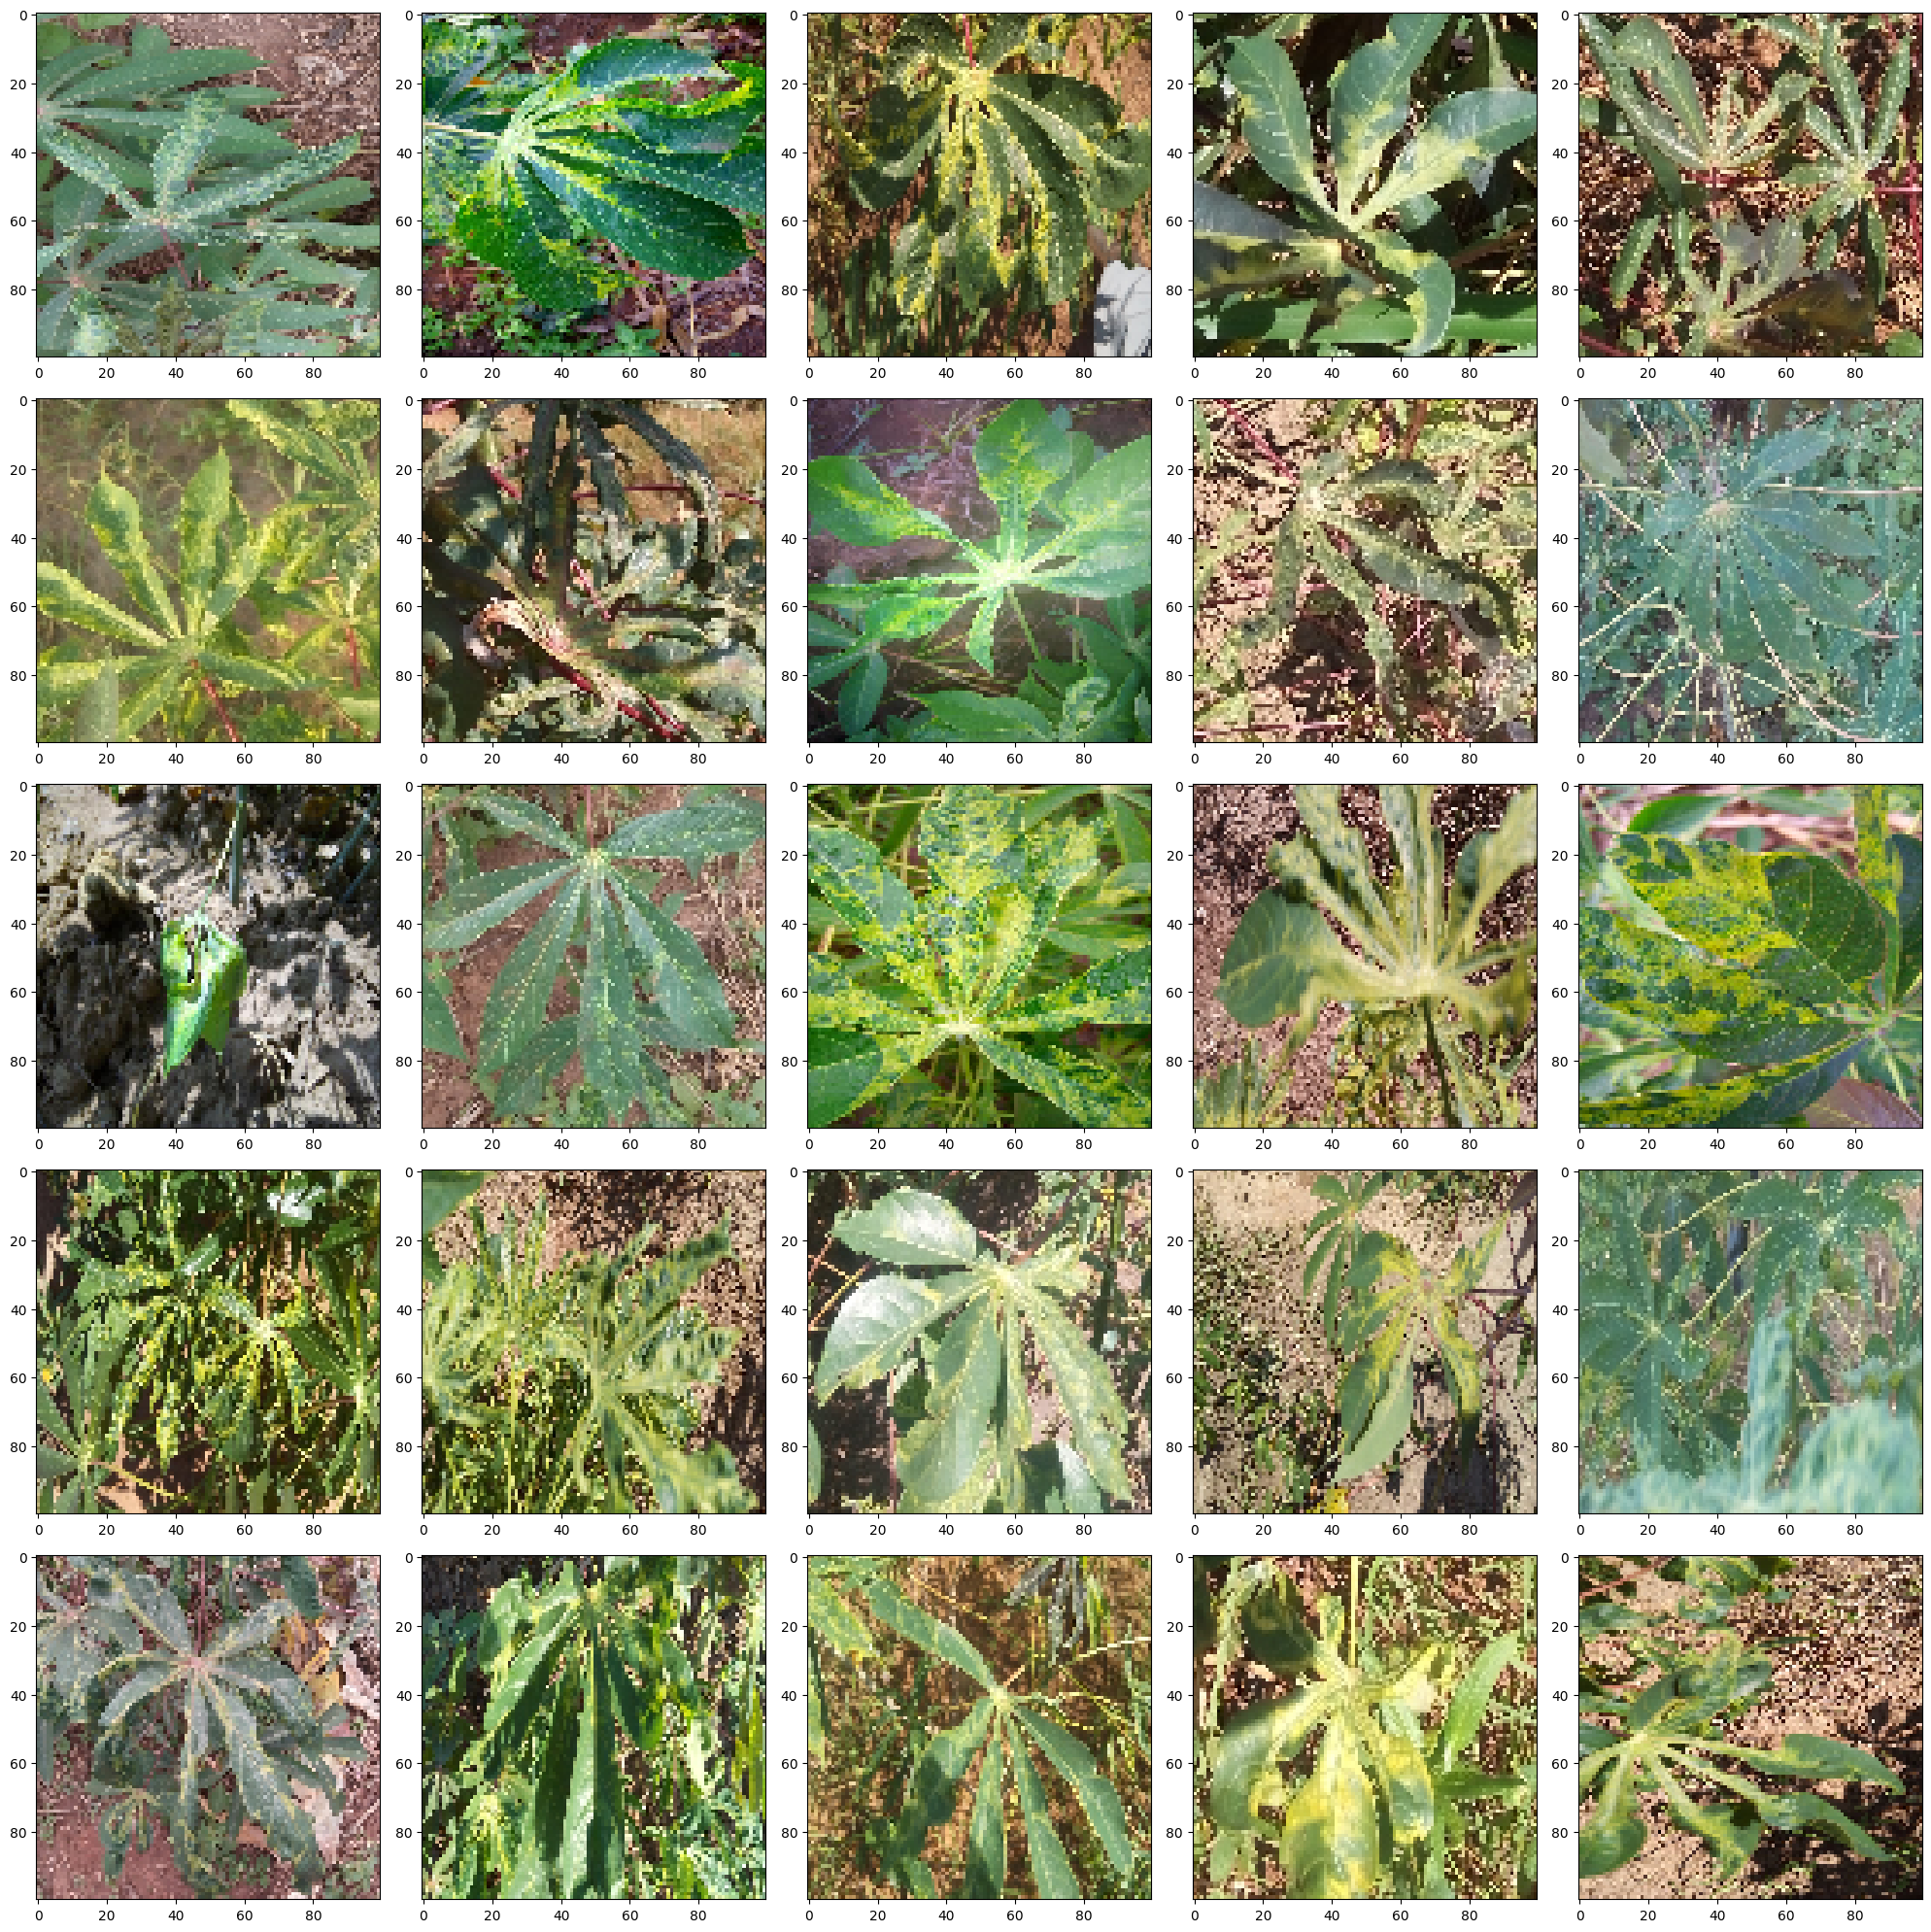

In [ ]:
images = [x_train[i] for i in range(25)]
fig, axes = plt.subplots(5, 5, figsize = (20, 20))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
batch_size = 16

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [ ]:
# model = Sequential()

# ## FIRST SET OF LAYERS

# # CONVOLUTIONAL LAYER
# model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(32, 32, 3), activation='relu',))
# # POOLING LAYER
# model.add(MaxPool2D(pool_size=(2, 2)))

# ## SECOND SET OF LAYERS

# # CONVOLUTIONAL LAYER
# model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(32, 32, 3), activation='relu',))
# # POOLING LAYER
# model.add(MaxPool2D(pool_size=(2, 2)))

# # FLATTEN IMAGES FROM 28 by 28 to 764 BEFORE FINAL LAYER
# model.add(Flatten())

# # 256 NEURONS IN DENSE HIDDEN LAYER (YOU CAN CHANGE THIS NUMBER OF NEURONS)
# model.add(Dense(256, activation='relu'))

# # LAST LAYER IS THE CLASSIFIER, THUS 10 POSSIBLE CLASSES
# model.add(Dense(10, activation='softmax'))


# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
x_train, y_train = shuffle(x_train,y_train, random_state=42)

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)
print(x_train.shape)

(1132, 100, 100, 3)
(4524, 100, 100, 3)


In [ ]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = datagen.flow(x_val, y_val, batch_size=batch_size)

print(x_val.shape)
print(x_train.shape)

(1132, 100, 100, 3)
(4524, 100, 100, 3)


In [ ]:
# net = ResNet50(
#     weights='imagenet', # Load weights pre-trained on ImageNet.
#      include_top=False, # Do not include the ImageNet classifier at the top.
#      input_shape=(image_size,image_size,3))

In [ ]:

net = MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))


17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
print(net)

In [ ]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(5, activation="softmax", kernel_regularizer=l2(0.01))(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 50, 50, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 50, 50, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 50, 50, 32)        128   

In [ ]:
# %load_ext tensorboard


# class_names = list(labels)
# def plot_to_image(figure):
#     buf = io.BytesIO()
#     plt.savefig(buf, format='png')
#     plt.close(figure)
#     buf.seek(0)

#     digit = tf.image.decode_png(buf.getvalue(), channels=4)
#     digit = tf.expand_dims(digit, 0)

#     return digit

# def plot_confusion_matrix(cm, class_names):
#     figure = plt.figure(figsize=(8, 8))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
#     plt.title("Confusion matrix")
#     plt.colorbar()
#     tick_marks = np.arange(len(class_names))
#     plt.xticks(tick_marks, class_names, rotation=45)
#     plt.yticks(tick_marks, class_names)

#     cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
#     threshold = cm.max() / 2.
# #
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         color = "white" if cm[i, j] > threshold else "black"
#         plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

#     return figure

# # Following function will make predictions from the model and log the confusion matrix as an image.
# def log_confusion_matrix(epoch, logs):
#     predictions = np.argmax(model.predict(x_test), axis=1)
#     cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
#     figure = plot_confusion_matrix(cm, class_names=class_names)
#     cm_image = plot_to_image(figure)

#     with file_writer_cm.as_default():
#         tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# # Remove previous log folder
# !rm -fr logs
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# # Run tensorBoard
# %tensorboard --logdir logs

In [ ]:
# early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [ ]:
model.fit(x_train,y_train,epochs=15,validation_data=(x_test,y_test))

Epoch 1/15
142/142 [==============================] - 36s 76ms/step - loss: 2.0733 - accuracy: 0.4772 - val_loss: 5.4834 - val_accuracy: 0.0488
Epoch 2/15
142/142 [==============================] - 6s 44ms/step - loss: 1.1790 - accuracy: 0.6587 - val_loss: 4.9013 - val_accuracy: 0.0917
Epoch 3/15
142/142 [==============================] - 6s 41ms/step - loss: 0.8527 - accuracy: 0.7403 - val_loss: 6.0643 - val_accuracy: 0.0639
Epoch 4/15
142/142 [==============================] - 6s 44ms/step - loss: 0.5875 - accuracy: 0.8234 - val_loss: 7.2499 - val_accuracy: 0.0652
Epoch 5/15
142/142 [==============================] - 6s 43ms/step - loss: 0.4961 - accuracy: 0.8541 - val_loss: 7.6050 - val_accuracy: 0.0700
Epoch 6/15
142/142 [==============================] - 6s 41ms/step - loss: 0.3639 - accuracy: 0.8996 - val_loss: 7.4393 - val_accuracy: 0.0588
Epoch 7/15
142/142 [==============================] - 6s 45ms/step - loss: 0.3116 - accuracy: 0.9180 - val_loss: 8.6373 - val_accuracy: 0.060

In [ ]:
import pandas as pd
import numpy as np
losses = pd.DataFrame(model.history.history)

In [ ]:
losses.head()

loss  accuracy  val_loss  val_accuracy
0  2.073303  0.477233  5.483430      0.048755
1  1.179044  0.658709  4.901309      0.091680
2  0.852723  0.740274  6.064301      0.063858
3  0.587495  0.823386  7.249932      0.065183
4  0.496054  0.854111  7.605045      0.069952

<Axes: title={'center': 'Training acuration and Validation Graph'}>

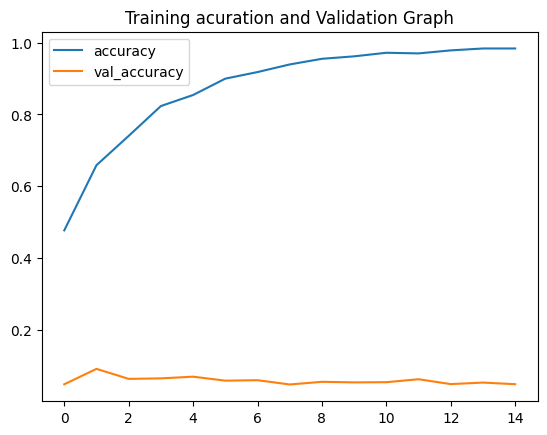

In [ ]:
losses[['accuracy','val_accuracy']].plot(title='Training acuration and Validation Graph')

<Axes: title={'center': 'Training and Validation Loss Graph'}>

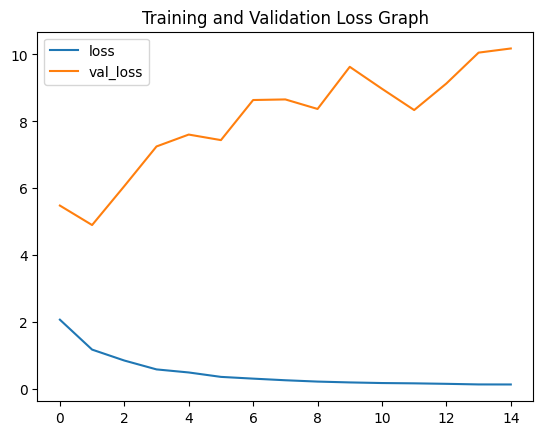

In [ ]:
losses[['loss','val_loss']].plot(title='Training and Validation Loss Graph')

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
print(model.metrics_names)
print(model.evaluate(x_test,y_test,verbose=0))

['loss', 'accuracy']
[10.177553176879883, 0.04901960864663124]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict(x_test)

118/118 [==============================] - 2s 10ms/step


In [ ]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

118/118 [==============================] - 1s 11ms/step
[0 3 0 ... 0 0 0]


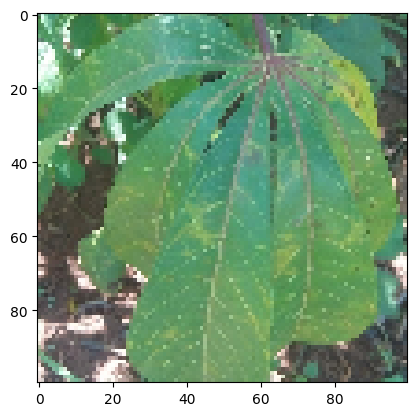

In [ ]:
image = x_test[16]
plt.imshow(image)

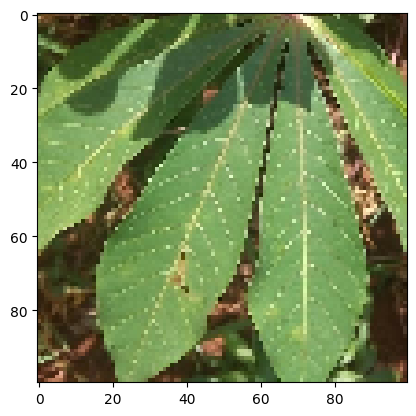

In [ ]:
image = x_test[9]
plt.imshow(image)

In [ ]:
# rounded_predictions = np.round(predictions)
# predicted_classes = np.argmax(rounded_predictions, axis=1)
# print(classification_report(y_test, predicted_classes))

118/118 [==============================] - 1s 12ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.05      0.09      3774

    accuracy                           0.05      3774
   macro avg       0.20      0.01      0.02      3774
weighted avg       1.00      0.05      0.09      3774



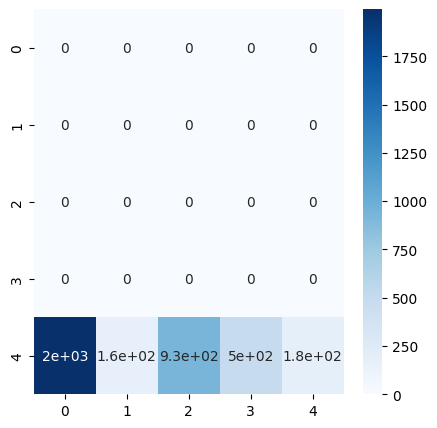

In [ ]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (5, 5))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

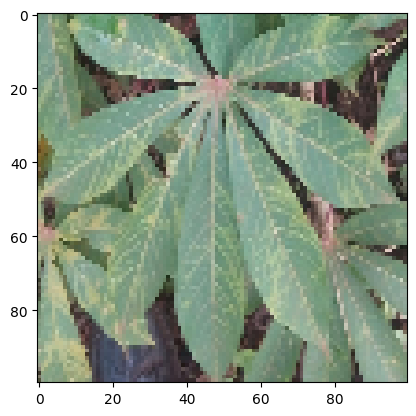

In [ ]:
image = x_test[44]
plt.imshow(image)

In [ ]:
test_index = 44

test_image = np.expand_dims(x_test[test_index], axis=0)

prediction = model.predict(test_image)
predicted_class = np.argmax(prediction)

print(f"Predicted Class: {labels[predicted_class]}")

1/1 [==============================] - 0s 222ms/step
Predicted Class: cbsd


1/1 [==============================] - 0s 22ms/step


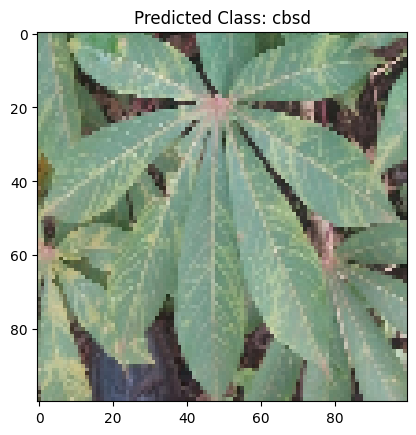

1/1 [==============================] - 0s 27ms/step


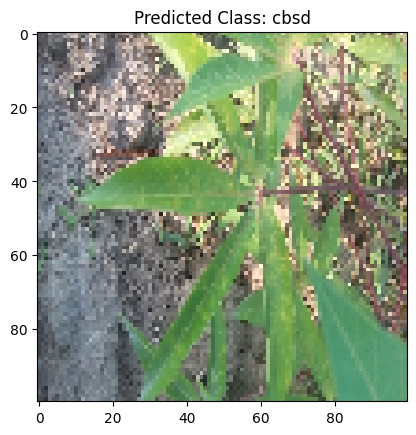

1/1 [==============================] - 0s 24ms/step


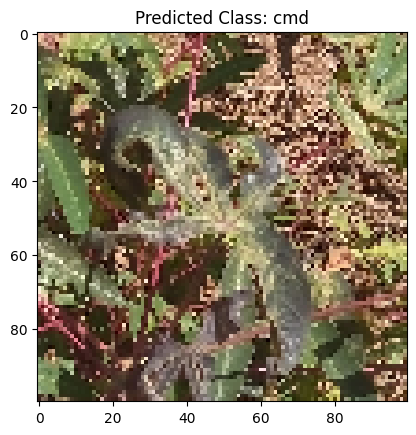

In [ ]:
import matplotlib.pyplot as plt

test_indices = [44, 55, 66]  # Ganti dengan indeks gambar yang ingin di uji

for test_index in test_indices:
    test_image = np.expand_dims(x_test[test_index], axis=0)

    prediction = model.predict(test_image)
    predicted_class = np.argmax(prediction)

    plt.imshow(x_test[test_index])
    plt.title(f"Predicted Class: {labels[predicted_class]}")
    plt.show()


1/1 [==============================] - 0s 21ms/step


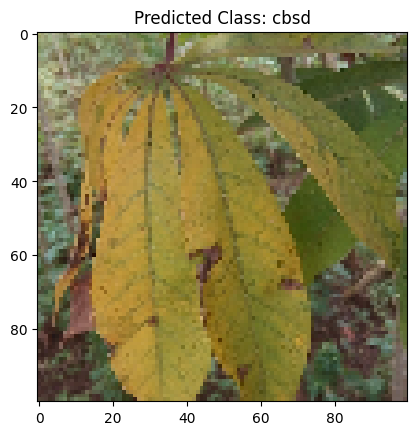

1/1 [==============================] - 0s 25ms/step


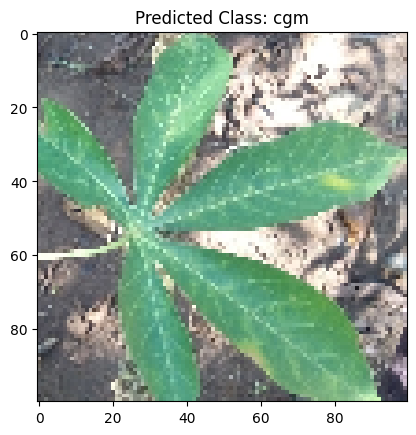

1/1 [==============================] - 0s 20ms/step


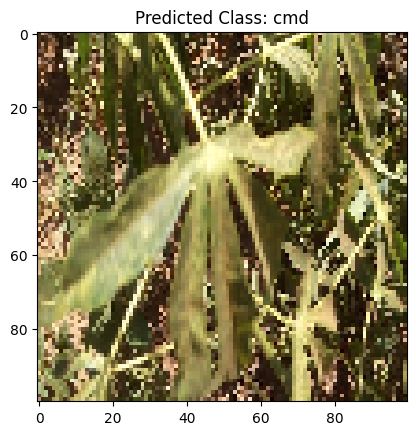

1/1 [==============================] - 0s 20ms/step


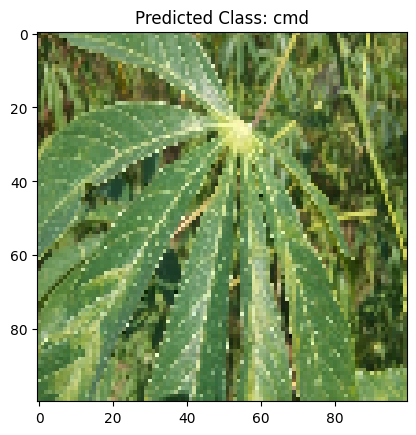

1/1 [==============================] - 0s 21ms/step


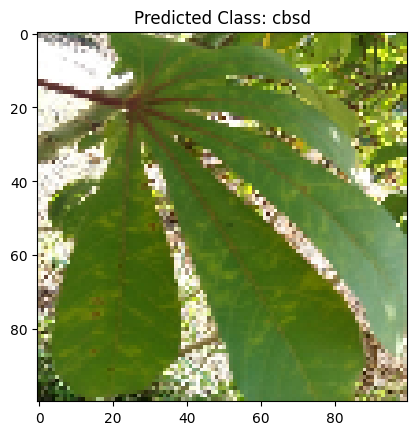

1/1 [==============================] - 0s 20ms/step


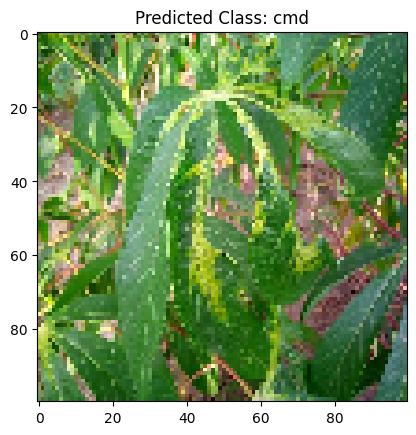

1/1 [==============================] - 0s 23ms/step


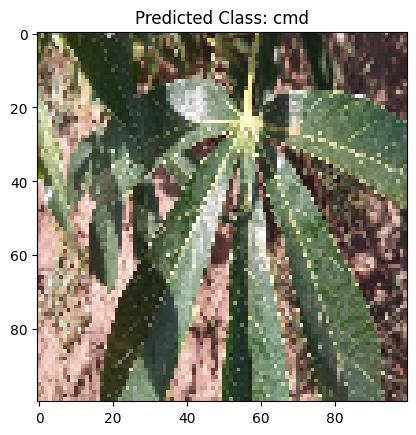

1/1 [==============================] - 0s 22ms/step


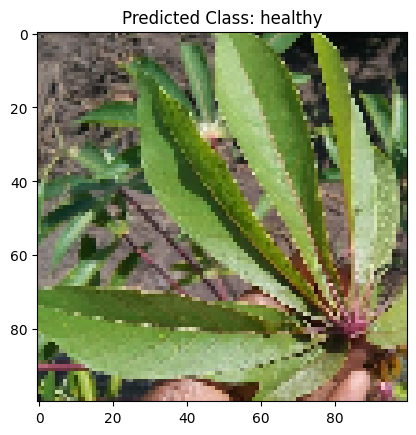

1/1 [==============================] - 0s 25ms/step


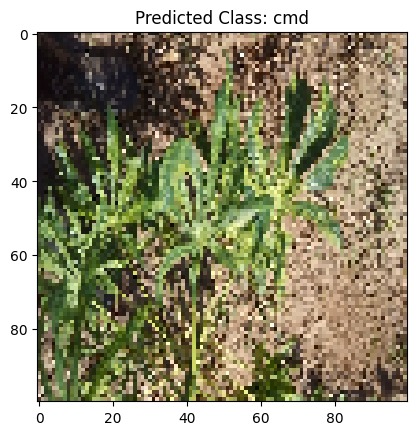

1/1 [==============================] - 0s 20ms/step


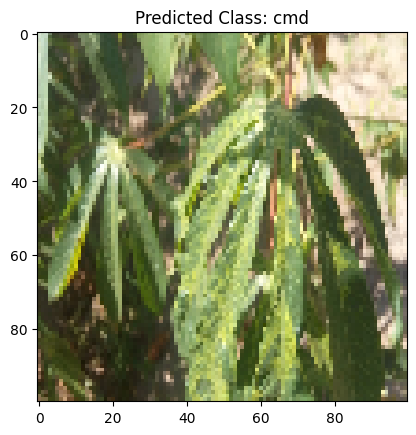

1/1 [==============================] - 0s 20ms/step


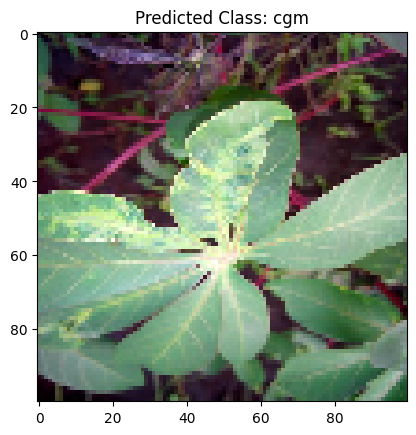

1/1 [==============================] - 0s 21ms/step


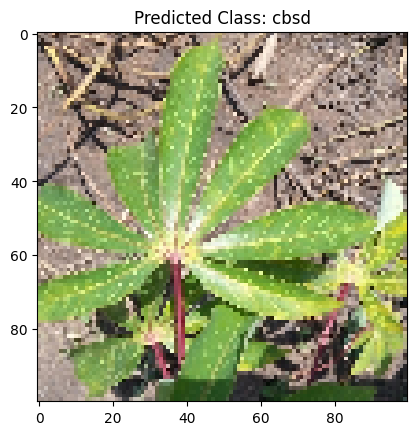

1/1 [==============================] - 0s 20ms/step


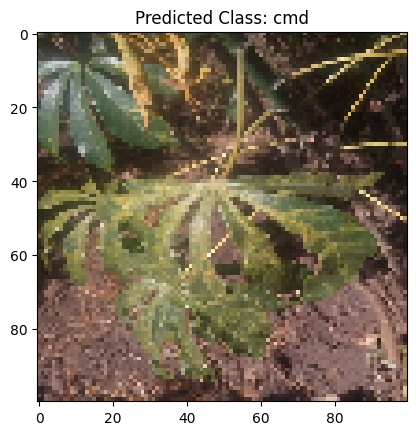

1/1 [==============================] - 0s 19ms/step


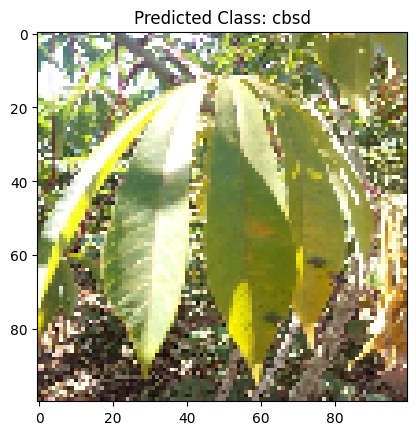

1/1 [==============================] - 0s 25ms/step


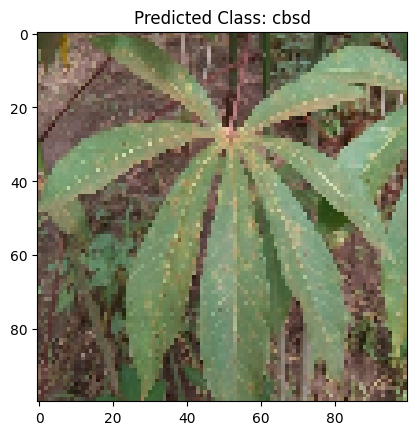

1/1 [==============================] - 0s 32ms/step


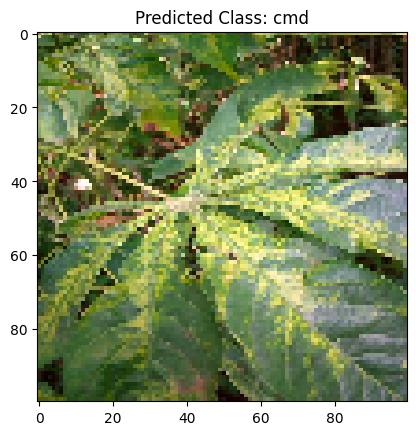

1/1 [==============================] - 0s 31ms/step


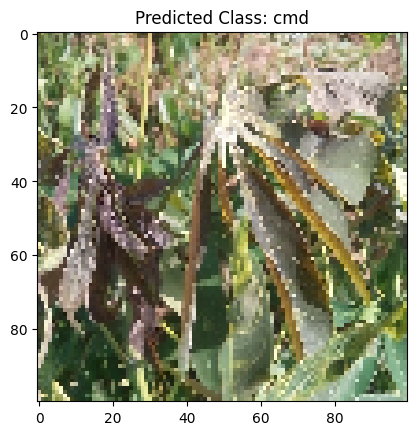

1/1 [==============================] - 0s 32ms/step


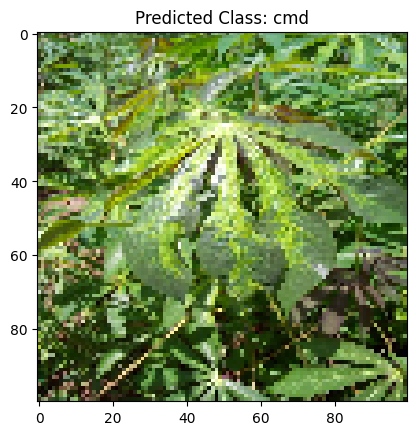

1/1 [==============================] - 0s 28ms/step


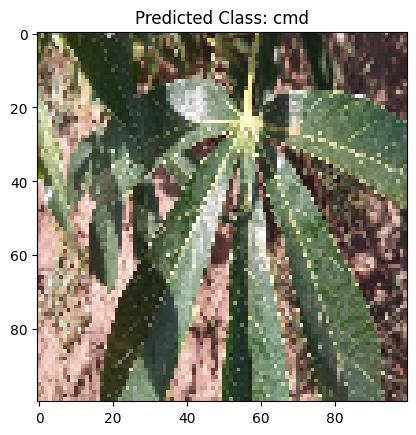

1/1 [==============================] - 0s 45ms/step


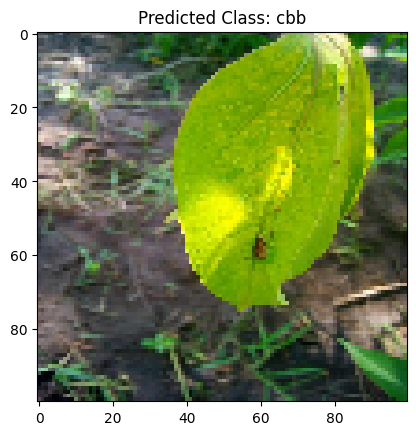

1/1 [==============================] - 0s 34ms/step


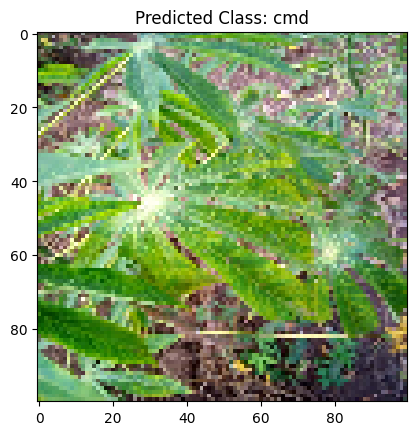

1/1 [==============================] - 0s 38ms/step


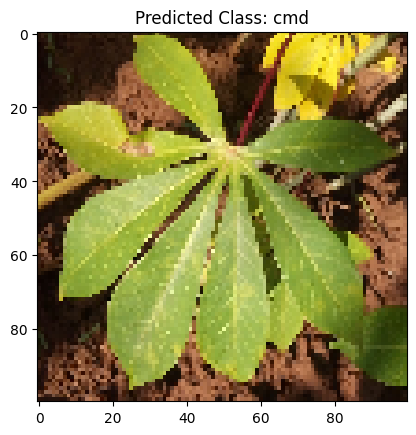

1/1 [==============================] - 0s 30ms/step


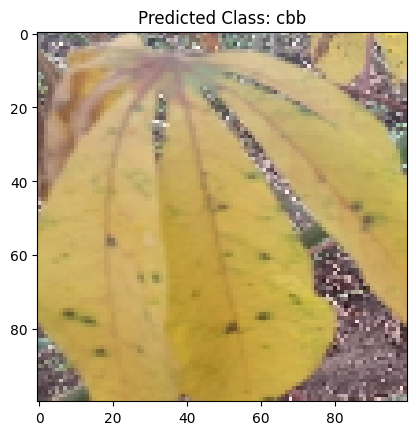

1/1 [==============================] - 0s 36ms/step


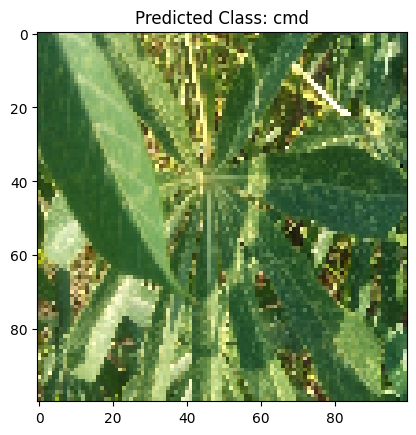

1/1 [==============================] - 0s 35ms/step


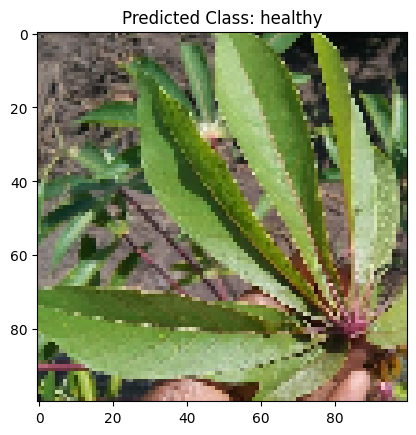

1/1 [==============================] - 0s 30ms/step


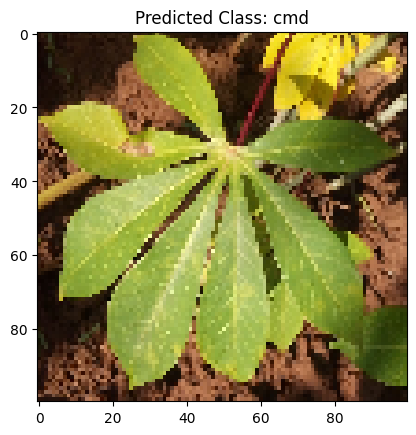

1/1 [==============================] - 0s 44ms/step


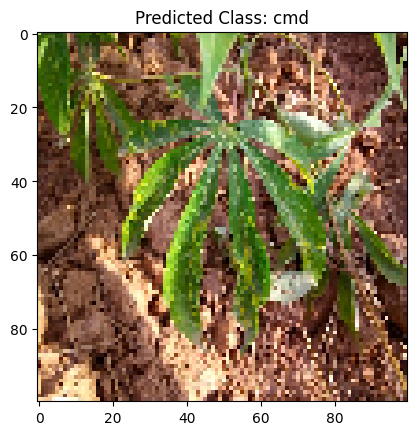

1/1 [==============================] - 0s 31ms/step


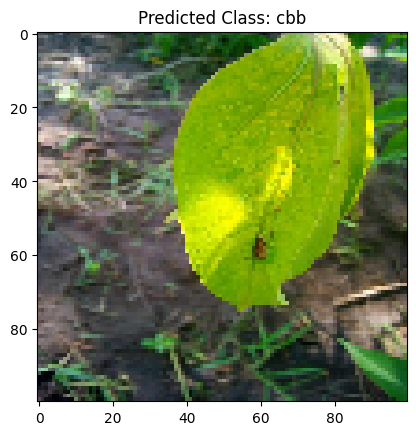

1/1 [==============================] - 0s 36ms/step


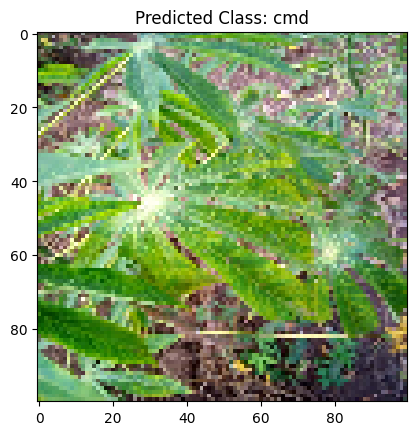

1/1 [==============================] - 0s 31ms/step


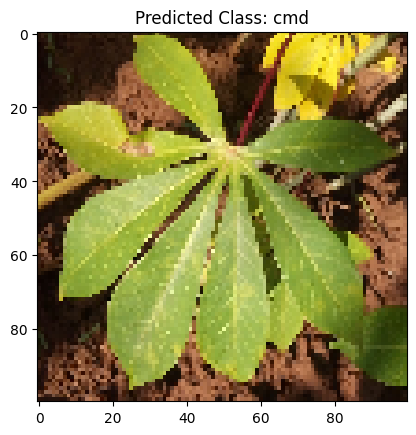

1/1 [==============================] - 0s 31ms/step


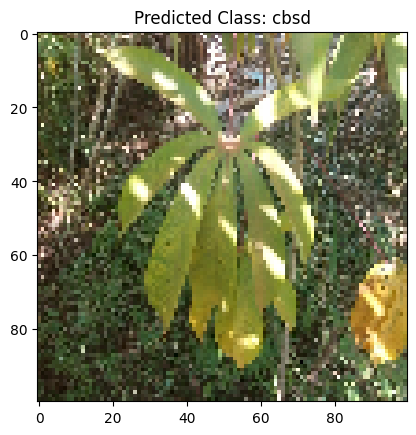

1/1 [==============================] - 0s 48ms/step


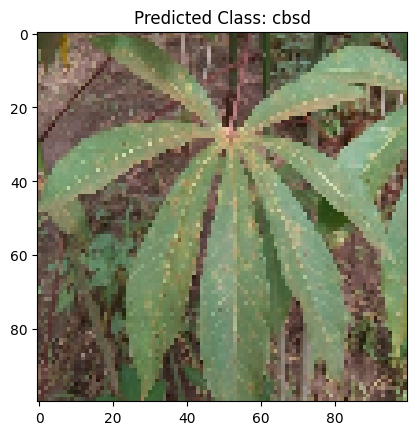

1/1 [==============================] - 0s 36ms/step


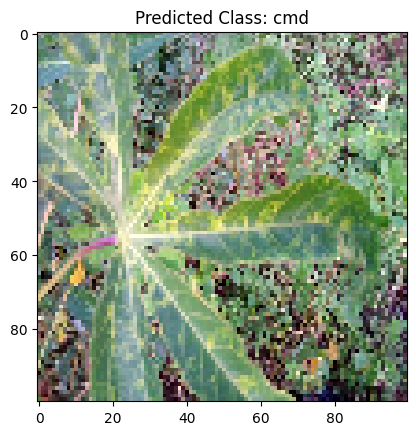

1/1 [==============================] - 0s 33ms/step


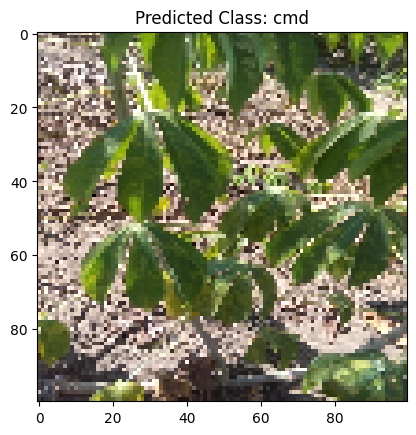

1/1 [==============================] - 0s 32ms/step


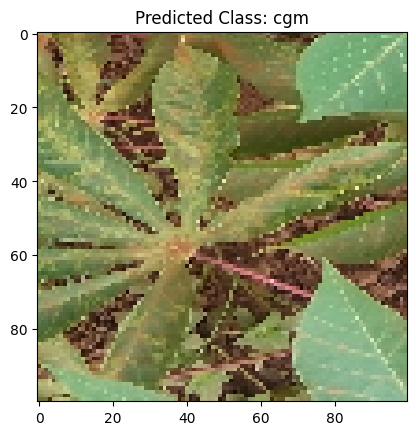

1/1 [==============================] - 0s 21ms/step


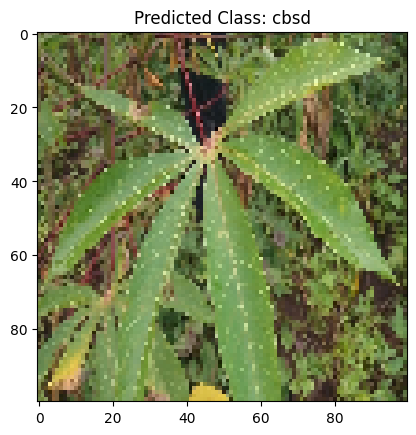

1/1 [==============================] - 0s 19ms/step


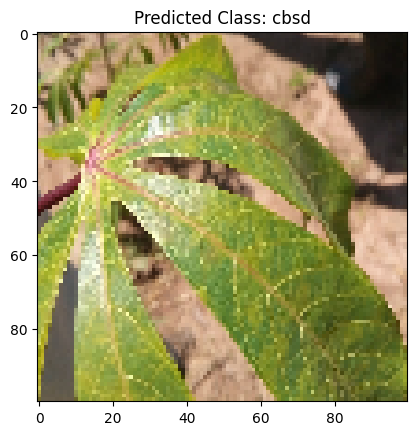

1/1 [==============================] - 0s 22ms/step


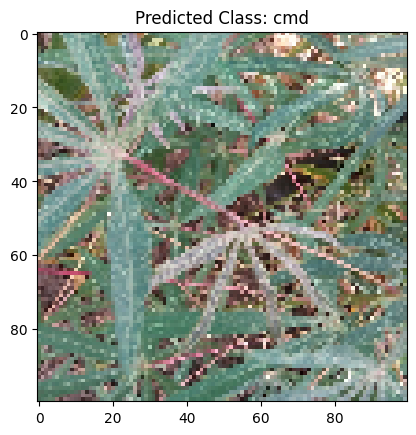

1/1 [==============================] - 0s 27ms/step


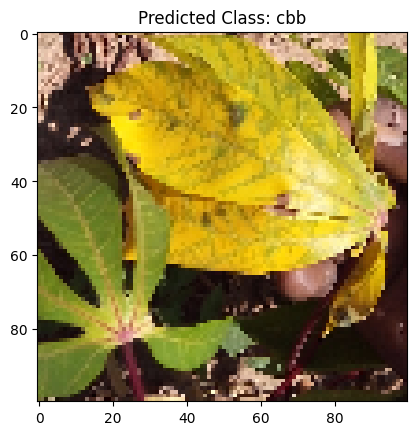

1/1 [==============================] - 0s 21ms/step


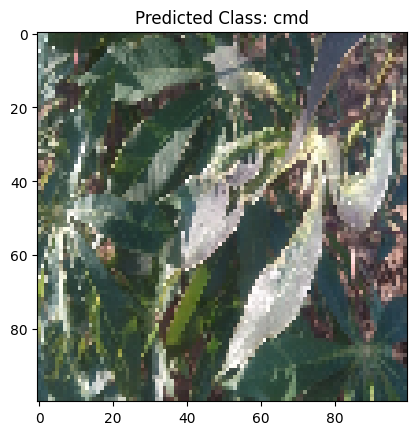

1/1 [==============================] - 0s 19ms/step


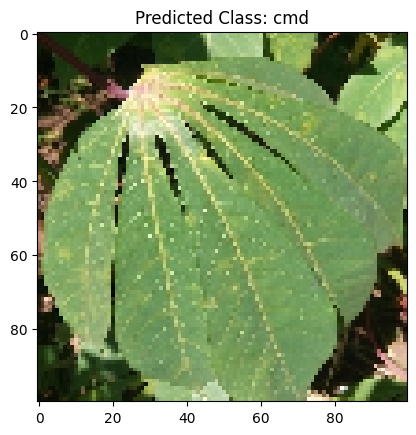

1/1 [==============================] - 0s 21ms/step


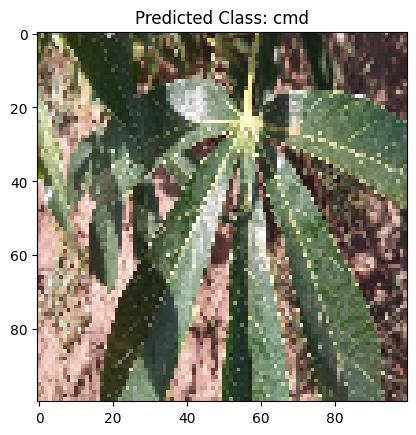

In [ ]:
test_indices = [877,988,558,992,887,568,76,46,344,57,88,334,64,22,67,87,234,45,76,23,56,78,53,13,46,78,32,23,56,78,34,67,656,39,97,24,82,68,27,255,36,76]  # Ganti dengan indeks gambar yang ingin di uji

for test_index in test_indices:
    test_image = np.expand_dims(x_test[test_index], axis=0)

    prediction = model.predict(test_image)
    predicted_class = np.argmax(prediction)

    plt.imshow(x_test[test_index])
    plt.title(f"Predicted Class: {labels[predicted_class]}")
    plt.show()